# Построение моделей для решения задачи классификации (бинарная)

## Импорт необходимых библиотек

In [224]:
import numpy as np
import pandas as pd
import json
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc
from scipy.stats import loguniform, uniform, randint

Загрузка датасета

Целевой признак - bomb_planted

In [225]:
data = pd.read_csv('csgo_filtred.csv')

y = data['bomb_planted']
X = data.drop(columns=['bomb_planted'], axis=1)

## Проверка баланса классов

In [226]:
X.head()

,time_left,ct_score,t_score,map,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,health_lead,armor_lead,money_lead,helmets_lead,players_alive_lead
0,175.00,0,0,de_dust2,500,500,0,0,4000,4000,0,0,0,5,5,2,2,2,2,2
1,156.03,0,0,de_dust2,500,500,400,300,600,650,0,0,1,5,5,2,0,1,2,2
2,96.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
3,76.03,0,0,de_dust2,391,400,294,200,750,500,0,0,1,4,4,1,0,0,2,2
4,174.97,1,0,de_dust2,500,500,192,0,18350,10750,0,0,1,5,5,2,0,0,2,2


<Axes: ylabel='bomb_planted'>

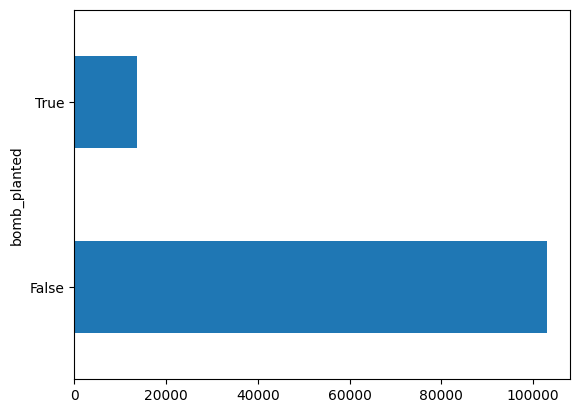

In [227]:
y.value_counts().plot.barh()

In [228]:
y.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

Видно, что классы максимально несбалансированы, количество класса false превосходит класс true более чем в 5 раз.

Для балансировки буду использовать метод SMOTE, он создаёт дополнительные точки для минаритарного класса, основываясь на уже существующих точках.

Но для начала преобразую переменные признака map в числовые.

In [229]:
X['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [230]:
X['map'] = X['map'].str.strip().str.lower()

In [231]:
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X['map'] = X['map'].map(mapping)
X['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

In [232]:
oversample = SMOTE()
transformed_X, tranformed_y = oversample.fit_resample(X, y)

In [233]:
print(f'OLD: {y.value_counts()}')
print()
print(f'NEW: {tranformed_y.value_counts()}')

OLD: bomb_planted
False    102945
True      13684
Name: count, dtype: int64

NEW: bomb_planted
False    102945
True     102945
Name: count, dtype: int64


In [234]:
X, y = transformed_X, tranformed_y

In [235]:
X.duplicated().sum()

np.int64(0)

Как можно увидеть балансировка по классам получилась успешной, теперь мы имеем два класса с одинаковым количеством точек.

## Разделение на тренировочную и тестовую выборки

In [236]:
# Метод train_test_split с использованием stratify

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.5, stratify=y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((102945, 20), (102945,), (20589, 20), (20589,))

In [237]:
X_train_search, X_test_search, y_train_search, y_test_search = train_test_split(X, y, random_state=42, train_size=0.05, stratify=y, test_size=0.01)
X_train_search.shape, y_train_search.shape, X_test_search.shape, y_test_search.shape

((10294, 20), (10294,), (2059, 20), (2059,))

In [238]:
# KFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [239]:
# Маштабирование

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_search = scaler.fit_transform(X_train_search)
X_test_search = scaler.transform(X_test_search)

## Вычисление лучший гиперпараметров для моделей

По заданию необходимо использовать такие модели классификации как:

- `Logistic Regression`
- `kNN`
- `Naive Bayes`
- `SVM` (в том числе ядерные функции (Linear Kernel, Polynomial Kernel, RBF Kernel, Sigmoid Kernel, Exponential Kernel))

Для начала найду для всех этих моделей лучшие гиперпараметры

`ВАЖНО!` Датасет после балансировки классов состоит из 200тыс объектов, искать гиперпараметры на таком объёмы это потрать дни, поэтому в самом начале специально были созданы выборки по 10тыс объектов для поиска гиперпараметров, далее применяя наиденные гиперпараметры в моделях, буду обучать их на 100тыс объектах.

Сохранение словаря как json файла, чтобы не вычислять его повторно

In [240]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

## Обучение моделей

In [241]:
def metrics(pred_array, true_array=y_test,):
    print(f'F1: {f1_score(true_array, pred_array)}')
    print(f'accuracy: {accuracy_score(true_array, pred_array)}')
    print(f'precision: {precision_score(true_array, pred_array)}')
    print(f'recall: {recall_score(true_array, pred_array)}')
    print(f'roc_auc_score: {roc_auc_score(true_array, pred_array)}')

Logistic Regression

In [242]:
model_lr = joblib.load(r'models\logistic_regression_model')

kNN

In [243]:
model_knn = joblib.load(r'models\knn_model')

Naive Bayes

In [244]:
model_nb = joblib.load(r'models\naive_bayes_model')

SVC(rbf)

In [245]:
model_svc_rbf = joblib.load(r'models\svc_rbf_model')

SVC(linear)

Модель будет обучена на маленькой выборке

In [246]:
model_svc_linear = joblib.load(r'models\svc_linear_model')

SVC(poly) size - 10000 objects

In [247]:
model_svc_poly = joblib.load(r'models/svc_poly_model')

SVC(sigmoid) size - 10000 object

In [248]:
model_svc_sigmoid = joblib.load(r'models\svc_sigmoid_model')

SVC(precomputed) size - 10000 objects

In [249]:
model_svc_precomputed = joblib.load(r'models\svc_precomputed_model')

# Вывод

Практический по всем метрикам модель опорных векторов с ядром 'linear' является лучше, следовательно для данной выборки лучшей моделью будет SVC (kernel='linear')